# 🔍 **EVALUATION DES NEURONALEN NETZES ZUR WERKZEUG-ERKENNUNG**

Das Notebook [semesterarbeit-training.ipynb](semesterarbeit-training.ipynb) produzierte als Ausgabe ein fertig trainiertes neuronales Netz, sowie eine Aufsplittung des Werkzeug-Datensatzes in einen Trainings- und einen Testdatensatz. Hier wollen wir das Modell laden und auf dem Testdatensatz evaluieren.

Die Daten wurden bereits im Training-Notebook extrahiert und in ZIP-Dateien (`training_Baumstruktur.zip` und `testing_Baumstruktur.zip`) gespeichert.

In [3]:
# Installiere alle benötigten Abhängigkeiten
import subprocess
import sys

def install_package(package_name, import_name=None):
    """Installiert ein Paket falls es nicht vorhanden ist"""
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        return True
    except ImportError:
        print(f"Installiere {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name], 
                                stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"✓ {package_name} wurde installiert")
            return True
        except Exception as e:
            print(f"✗ Fehler beim Installieren von {package_name}: {e}")
            return False

# Liste aller benötigten Pakete
required_packages = [
    ("tensorflow>=2.10.0", "tensorflow"),
    ("numpy>=1.20.0", "numpy"),
    ("matplotlib>=3.3.0", "matplotlib"),
    ("pandas>=1.3.0", "pandas"),
    ("scikit-learn>=1.0.0", "sklearn"),
    ("seaborn>=0.11.0", "seaborn"),
    ("scipy>=1.7.0,<1.11.0", "scipy"),
]

print("Prüfe Abhängigkeiten...")
all_installed = True
for package, import_name in required_packages:
    if not install_package(package, import_name):
        all_installed = False

# Spezielle Behandlung für scikit-plot
try:
    import scikitplot
    SKPLT_AVAILABLE = True
    print("✓ scikit-plot ist verfügbar")
except ImportError:
    SKPLT_AVAILABLE = False
    print("⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Visualisierungen.")
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Erstelle Mock-Objekt für scikit-plot
    class MockSkpltMetrics:
        def plot_confusion_matrix(self, y_true, y_pred, labels=None, x_tick_rotation=0, ax=None):
            cm = confusion_matrix(y_true, y_pred, labels=labels)
            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 8))
            
            # Bestimme die Labels für die Achsen
            if labels is not None:
                # Konvertiere zu Liste falls es ein numpy Array ist
                if hasattr(labels, 'tolist'):
                    tick_labels = labels.tolist()
                else:
                    tick_labels = list(labels)
            else:
                tick_labels = sorted(set(list(y_true) + list(y_pred)))
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                       xticklabels=tick_labels, 
                       yticklabels=tick_labels)
            ax.set_xlabel('Vorhergesagte Klasse')
            ax.set_ylabel('Tatsächliche Klasse')
            ax.set_title('Confusion Matrix')
            if x_tick_rotation:
                plt.setp(ax.get_xticklabels(), rotation=x_tick_rotation, ha='right')
            return ax
        
        def plot_precision_recall(self, y_true, y_proba, ax=None):
            from sklearn.metrics import precision_recall_curve, auc
            from sklearn.preprocessing import label_binarize
            
            classes = sorted(set(y_true))
            y_bin = label_binarize(y_true, classes=classes)
            
            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 8))
            
            for i, class_name in enumerate(classes):
                precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
                ax.plot(recall, precision, label=f'{class_name} (AUC={auc(recall, precision):.2f})')
            
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title('Precision-Recall Curve')
            return ax
        
        def plot_roc(self, y_true, y_proba, ax=None):
            from sklearn.metrics import roc_curve, auc
            from sklearn.preprocessing import label_binarize
            
            classes = sorted(set(y_true))
            y_bin = label_binarize(y_true, classes=classes)
            
            if ax is None:
                fig, ax = plt.subplots(figsize=(10, 8))
            
            for i, class_name in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
                ax.plot(fpr, tpr, label=f'{class_name} (AUC={auc(fpr, tpr):.2f})')
            
            ax.plot([0, 1], [0, 1], 'k--', label='Random')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title('ROC Curve')
            return ax
    
    class MockScikitplot:
        def __init__(self):
            self.metrics = MockSkpltMetrics()
    
    scikitplot = MockScikitplot()

if all_installed:
    print("\n✓ Alle Abhängigkeiten sind installiert!")

# Standard-Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
from pathlib import Path

Prüfe Abhängigkeiten...


d:\dev\anaconda\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


⚠ scikit-plot ist nicht verfügbar. Verwende sklearn.metrics für Visualisierungen.

✓ Alle Abhängigkeiten sind installiert!


In [4]:
# Prüfe ob die Baumstruktur bereits vorhanden ist oder aus ZIP-Dateien entpackt werden muss
import zipfile

Baumstrukturpfad = Path('Baumstruktur')
testBaumstrukturpfad = Baumstrukturpfad / 'Baumstruktur_test'

# Prüfe ob Test-Baumstruktur bereits existiert
if testBaumstrukturpfad.exists() and any(testBaumstrukturpfad.iterdir()):
    Baumstruktur_schon_vorhanden = True
    print(f"✓ Test-Baumstruktur gefunden: {testBaumstrukturpfad}")
else:
    # Versuche ZIP-Datei zu entpacken
    zip_test = Path('testing_Baumstruktur.zip')
    if zip_test.exists():
        print(f"Entpacke {zip_test}...")
        Baumstrukturpfad.mkdir(exist_ok=True)
        with zipfile.ZipFile(zip_test, 'r') as zip_ref:
            zip_ref.extractall(Baumstrukturpfad)
        testBaumstrukturpfad = Baumstrukturpfad / 'Baumstruktur_test'
        if not testBaumstrukturpfad.exists():
            testBaumstrukturpfad = Baumstrukturpfad / 'test'
        Baumstruktur_schon_vorhanden = True
        print(f"✓ Test-Daten entpackt: {testBaumstrukturpfad}")
    else:
        Baumstruktur_schon_vorhanden = False
        print(f"⚠ WARNUNG: {zip_test} nicht gefunden und keine Baumstruktur vorhanden!")

✓ Test-Baumstruktur gefunden: Baumstruktur\Baumstruktur_test


## 🔍 Diagnose: Datenanzahl prüfen

Diese Zelle zeigt, wie viele Bilder wo gefunden wurden und ob die Daten aktuell sind.


In [5]:
# ============================================================================
# DIAGNOSE: Prüfe Datenanzahl und -qualität
# ============================================================================
from pathlib import Path
import zipfile

print("=" * 70)
print("DATEN-DIAGNOSE")
print("=" * 70)

# Initialisiere Variablen
total_extracted = 0
total_train = 0
total_test = 0

# 1. Prüfe extracted-Ordner (aktuellste Daten)
extracted_path = Path('extracted')
if extracted_path.exists():
    print("\n1. Extrahierte Bilder (extracted/):")
    for klasse in ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']:
        klasse_path = extracted_path / klasse
        if klasse_path.exists():
            count = len(list(klasse_path.glob('*.*')))
            total_extracted += count
            print(f"   {klasse:20s}: {count:4d} Bilder")
    print(f"   {'GESAMT':20s}: {total_extracted:4d} Bilder")
else:
    print("\n1. Extrahierte Bilder: ❌ Ordner 'extracted' existiert nicht!")
    print("   → Führen Sie zuerst das Objektextraktions-Notebook aus!")

# 2. Prüfe ZIP-Dateien
print("\n2. ZIP-Dateien:")
zip_train = Path('training_Baumstruktur.zip')
zip_test = Path('testing_Baumstruktur.zip')

if zip_train.exists():
    size_mb = zip_train.stat().st_size / 1024 / 1024
    print(f"   ✓ training_Baumstruktur.zip: {size_mb:.2f} MB")
else:
    print(f"   ❌ training_Baumstruktur.zip: FEHLT")
    print("      → Führen Sie das Objektextraktions-Notebook aus, um ZIP zu erstellen!")

if zip_test.exists():
    size_mb = zip_test.stat().st_size / 1024 / 1024
    print(f"   ✓ testing_Baumstruktur.zip: {size_mb:.2f} MB")
else:
    print(f"   ❌ testing_Baumstruktur.zip: FEHLT")
    print("      → Führen Sie das Objektextraktions-Notebook aus, um ZIP zu erstellen!")

# 3. Prüfe entpackte Baumstruktur
print("\n3. Entpackte Baumstruktur (Baumstruktur/):")
baumstruktur_path = Path('Baumstruktur')
if baumstruktur_path.exists():
    train_path = baumstruktur_path / 'Baumstruktur_train'
    test_path = baumstruktur_path / 'Baumstruktur_test'
    
    if train_path.exists():
        print(f"   ✓ Train-Ordner: {train_path}")
        for klasse_dir in train_path.iterdir():
            if klasse_dir.is_dir():
                count = len(list(klasse_dir.glob('*.*')))
                total_train += count
                print(f"      {klasse_dir.name:20s}: {count:4d} Bilder")
        print(f"      {'GESAMT':20s}: {total_train:4d} Bilder")
    else:
        print(f"   ❌ Train-Ordner fehlt: {train_path}")
    
    if test_path.exists():
        print(f"   ✓ Test-Ordner: {test_path}")
        for klasse_dir in test_path.iterdir():
            if klasse_dir.is_dir():
                count = len(list(klasse_dir.glob('*.*')))
                total_test += count
                print(f"      {klasse_dir.name:20s}: {count:4d} Bilder")
        print(f"      {'GESAMT':20s}: {total_test:4d} Bilder")
    else:
        print(f"   ❌ Test-Ordner fehlt: {test_path}")
else:
    print(f"   ❌ Baumstruktur-Ordner existiert nicht!")
    print("      → Führen Sie das Training-Notebook aus, um Daten zu entpacken!")

# 4. Vergleich und Empfehlungen
print("\n4. Vergleich und Empfehlungen:")
if extracted_path.exists() and baumstruktur_path.exists():
    total_baumstruktur = total_train + total_test
    if total_extracted > total_baumstruktur:
        diff = total_extracted - total_baumstruktur
        print(f"   ⚠️ WARNUNG: {diff} neue Bilder in 'extracted/' gefunden!")
        print(f"      → Extrahierte Bilder: {total_extracted}")
        print(f"      → In Baumstruktur: {total_baumstruktur} ({total_train} Train + {total_test} Test)")
        print(f"      → Führen Sie das Objektextraktions-Notebook aus, um:")
        print(f"         1. Alle {total_extracted} Bilder zu verarbeiten")
        print(f"         2. Train/Test Split durchzuführen (80/20)")
        print(f"         3. ZIP-Dateien neu zu erstellen")
    elif total_extracted < total_baumstruktur:
        diff = total_baumstruktur - total_extracted
        print(f"   ⚠️ HINWEIS: {diff} Bilder mehr in Baumstruktur als in extracted/")
        print(f"      → Dies kann passieren, wenn Bilder mehrfach extrahiert wurden")
        print(f"      → Oder wenn die ZIP-Dateien neuere Daten enthalten")
    else:
        print(f"   ✓ Alle extrahierten Bilder sind in Train/Test aufgeteilt")
        print(f"      → Extrahierte: {total_extracted} = Train {total_train} + Test {total_test}")
        print(f"      → Verhältnis: {total_train/total_extracted*100:.1f}% Train, {total_test/total_extracted*100:.1f}% Test")

print("\n" + "=" * 70)


DATEN-DIAGNOSE

1. Extrahierte Bilder (extracted/):
   GESAMT              :    0 Bilder

2. ZIP-Dateien:
   ✓ training_Baumstruktur.zip: 0.54 MB
   ✓ testing_Baumstruktur.zip: 0.14 MB

3. Entpackte Baumstruktur (Baumstruktur/):
   ✓ Train-Ordner: Baumstruktur\Baumstruktur_train
      schraubenschluessel :   66 Bilder
      schraubenzieher     :   93 Bilder
      seidenschneider     :   90 Bilder
      GESAMT              :  249 Bilder
   ✓ Test-Ordner: Baumstruktur\Baumstruktur_test
      schraubenschluessel :   16 Bilder
      schraubenzieher     :   24 Bilder
      seidenschneider     :   23 Bilder
      GESAMT              :   63 Bilder

4. Vergleich und Empfehlungen:
   ⚠️ HINWEIS: 312 Bilder mehr in Baumstruktur als in extracted/
      → Dies kann passieren, wenn Bilder mehrfach extrahiert wurden
      → Oder wenn die ZIP-Dateien neuere Daten enthalten



In [6]:
# ============================================================================
# ALLE 3 MODELLE LADEN (Funktion ausgelagert in scripts/load_models.py)
# ============================================================================
# Die Modell-Lade-Logik wurde in scripts/load_models.py ausgelagert

from load_models import load_all_models

Datensatzname = 'Werkzeuge'  # Muss mit dem Training-Notebook übereinstimmen

# Erwartete Klassenreihenfolge aus Training-Notebook (Zelle 10)
# WICHTIG: Kopieren Sie diese aus dem Training-Notebook Zelle 10 (PRÜFUNG 1)!
expected_class_names = ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']

# Lade alle Modelle
models_dict, expected_class_names = load_all_models(
    datensatzname=Datensatzname,
    expected_class_names=expected_class_names
)

# Speichere Modelle in globalen Variablen für Kompatibilität
if 'Modell 1 (Simple CNN)' in models_dict:
    loaded_model1 = models_dict['Modell 1 (Simple CNN)']
if 'Modell 2 (Transfer Learning)' in models_dict:
    loaded_model2 = models_dict['Modell 2 (Transfer Learning)']
if 'Modell 3 (Standard)' in models_dict:
    loaded_model3 = models_dict['Modell 3 (Standard)']

# Speichere erwartete Klassenreihenfolge für spätere Verwendung
globals()['expected_class_names'] = expected_class_names

ModuleNotFoundError: No module named 'load_models'

In [ ]:
# ============================================================================
# IMPORT EVALUATION FUNKTIONEN
# ============================================================================
# Importiere die Evaluation-Funktionen aus scripts/evaluate_model.py

import sys
from pathlib import Path

# Füge scripts-Ordner zum Python-Pfad hinzu
scripts_path = Path('scripts')
if scripts_path.exists():
    scripts_abs_path = str(scripts_path.absolute())
    if scripts_abs_path not in sys.path:
        sys.path.insert(0, scripts_abs_path)
    print(f"✓ scripts-Ordner zum Python-Pfad hinzugefügt: {scripts_abs_path}")
else:
    print(f"⚠ Warnung: scripts-Ordner nicht gefunden: {scripts_path.absolute()}")

# Importiere die Funktionen einzeln für bessere Fehlerbehandlung
imported_functions = {}

try:
    from evaluate_model import full_evaluation, create_comparison_table, evaluate_all_models, check_class_order_consistency
    imported_functions['full_evaluation'] = full_evaluation
    imported_functions['create_comparison_table'] = create_comparison_table
    imported_functions['evaluate_all_models'] = evaluate_all_models
    imported_functions['check_class_order_consistency'] = check_class_order_consistency
    print("✓ evaluate_model Funktionen importiert")
except ImportError as e:
    print(f"⚠ evaluate_model Funktionen konnten nicht importiert werden: {e}")
    print(f"   Fehlerdetails: {type(e).__name__}: {str(e)}")
    # Versuche einzelne Imports
    try:
        from evaluate_model import full_evaluation
        imported_functions['full_evaluation'] = full_evaluation
        print("✓ full_evaluation() importiert")
    except ImportError:
        print("⚠ full_evaluation() konnte nicht importiert werden")
    
    try:
        from evaluate_model import create_comparison_table
        imported_functions['create_comparison_table'] = create_comparison_table
        print("✓ create_comparison_table() importiert")
    except ImportError:
        print("⚠ create_comparison_table() konnte nicht importiert werden")

try:
    from load_test_data import lade_testdaten_mit_pfad
    imported_functions['lade_testdaten_mit_pfad'] = lade_testdaten_mit_pfad
    print("✓ load_test_data Funktionen importiert")
except ImportError as e:
    print(f"⚠ load_test_data Funktionen konnten nicht importiert werden: {e}")

try:
    from load_models import load_all_models
    imported_functions['load_all_models'] = load_all_models
    print("✓ load_models Funktionen importiert")
except ImportError as e:
    print(f"⚠ load_models Funktionen konnten nicht importiert werden: {e}")

if len(imported_functions) > 0:
    print(f"\n✓ {len(imported_functions)} Funktion(en) erfolgreich importiert:")
    for func_name in imported_functions.keys():
        print(f"  - {func_name}()")
else:
    print("\n❌ Keine Funktionen konnten importiert werden!")
    print("  Die Evaluation wird manuell durchgeführt.")


✓ scripts-Ordner zum Python-Pfad hinzugefügt: d:\dev\git\privat\Studium\dsci-semesterarebeit\scripts
⚠ evaluate_model Funktionen konnten nicht importiert werden: cannot import name 'evaluate_all_models' from 'evaluate_model' (d:\dev\git\privat\Studium\dsci-semesterarebeit\scripts\evaluate_model.py)
   Fehlerdetails: ImportError: cannot import name 'evaluate_all_models' from 'evaluate_model' (d:\dev\git\privat\Studium\dsci-semesterarebeit\scripts\evaluate_model.py)
✓ full_evaluation() importiert
✓ create_comparison_table() importiert
✓ load_test_data Funktionen importiert
✓ load_models Funktionen importiert

✓ 4 Funktion(en) erfolgreich importiert:
  - full_evaluation()
  - create_comparison_table()
  - lade_testdaten_mit_pfad()
  - load_all_models()


In [ ]:
# Zeige Status
print(f"Baumstruktur vorhanden: {Baumstruktur_schon_vorhanden}")
if Baumstruktur_schon_vorhanden:
    print(f"Test-Pfad: {testBaumstrukturpfad}")

Baumstruktur vorhanden: True
Test-Pfad: Baumstruktur\Baumstruktur_test


In [ ]:
if Baumstruktur_schon_vorhanden:
    # Stelle sicher, dass testBaumstrukturpfad definiert ist
    if 'testBaumstrukturpfad' not in globals():
        testBaumstrukturpfad = Baumstrukturpfad / '2_Baumstruktur_test'
        if not testBaumstrukturpfad.exists():
            testBaumstrukturpfad = Baumstrukturpfad / 'test'
    
    np.set_printoptions(suppress=True, linewidth=500)
    
    # Suche nach Bildern in verschiedenen Formaten
    image_extensions = ['*.JPEG']
    testBilder_fn = []
    for ext in image_extensions:
        testBilder_fn.extend(list(testBaumstrukturpfad.glob(f'*/*{ext[1:]}')))  # Entferne * für glob
    
    testBilder_fn = pd.Series(testBilder_fn)
    testKlassenlabel = pd.Series([fn.parent.name for fn in testBilder_fn], index=[fn.name for fn in testBilder_fn])
    y_test = testKlassenlabel
    print(f"✓ {len(testBilder_fn)} Test-Bilder gefunden in {len(testKlassenlabel.unique())} Klassen")
else:
    # Fallback: Versuche Excel-Datei zu laden (falls vorhanden)
    excel_path = Path('train_test_split.xlsx')
    if excel_path.exists():
        train_or_test = pd.read_excel(excel_path)
        train_or_test.columns = ['Dateiname','TrainOrTest']
        
        testBilder_fn = train_or_test[train_or_test['TrainOrTest']=='test']
        testKlassenlabel = train_or_test.Dateiname.map(lambda s:s[:s.find('_')])
        train_or_test['Klasse'] = testKlassenlabel
        y_test = testKlassenlabel[train_or_test['TrainOrTest']=='test']
        
        # Erstelle Baumstruktur aus extracted-Ordner
        extracted_path = Path('extracted')
        testBaumstrukturpfad = Path('Baumstruktur') / 'test'
        testBaumstrukturpfad.mkdir(parents=True, exist_ok=True)
        
        testBilder_fn_list = []
        for irow, row in testBilder_fn.iterrows():
            Dateiname, TrainOrTest, Klasse = (row.Dateiname, row.TrainOrTest, row.Klasse)
            # Suche in extracted-Ordner
            fullfilename = None
            for klasse_dir in extracted_path.iterdir():
                if klasse_dir.is_dir():
                    for img_file in klasse_dir.glob('*'):
                        if img_file.name == Dateiname:
                            fullfilename = img_file
                            break
                if fullfilename:
                    break
            
            if fullfilename and fullfilename.exists():
                (testBaumstrukturpfad / Klasse).mkdir(exist_ok=True, parents=True)
                shutil.copyfile(fullfilename, testBaumstrukturpfad / Klasse / Dateiname)
                testBilder_fn_list.append(testBaumstrukturpfad / Klasse / Dateiname)
        
        testBilder_fn = pd.Series(testBilder_fn_list)
        y_test = pd.Series([Path(fn).parent.name for fn in testBilder_fn], index=[Path(fn).name for fn in testBilder_fn])
        print(f"✓ {len(testBilder_fn)} Test-Bilder aus Excel-Datei kopiert")
    else:
        raise FileNotFoundError("Weder Baumstruktur noch Excel-Datei gefunden! Bitte führen Sie zuerst das Training-Notebook aus.")

y_test = pd.Series(y_test.values, index=testBilder_fn)

✓ 63 Test-Bilder gefunden in 3 Klassen


## Was ist `y_test`?

`y_test` enthält die **tatsächlichen (wahren) Klassenlabels** der Testbilder. Es gibt mehrere Varianten im Notebook:

- **`y_test`**: pandas Series mit Klassennamen als Strings (z.B. "schraubenschluessel", "schraubenzieher", "seidenschneider")
- **`y_test_numeric`**: numpy Array mit numerischen Labels (0, 1, 2, ...)
- **`y_test_label`**: pandas Series mit Klassennamen (konvertiert aus numerischen Labels)

Diese Variablen werden verwendet, um die Modellvorhersagen zu bewerten (Accuracy, Precision, Recall, F1-Score).


In [ ]:
# ============================================================================
# ERKLÄRUNG: Was ist y_test und was wird ausgegeben?
# ============================================================================
# Diese Zelle zeigt, was genau unter y_test gespeichert wird

print("="*70)
print("ERKLÄRUNG: y_test - Die tatsächlichen Klassenlabels der Testbilder")
print("="*70)

# Prüfe welche y_test Varianten vorhanden sind
print("\n📋 Verfügbare y_test Varianten:")
y_test_variants = []

if 'y_test' in globals():
    y_test_variants.append('y_test')
    print("  ✓ y_test vorhanden")
if 'y_test_numeric' in globals():
    y_test_variants.append('y_test_numeric')
    print("  ✓ y_test_numeric vorhanden")
if 'y_test_label' in globals():
    y_test_variants.append('y_test_label')
    print("  ✓ y_test_label vorhanden")

if len(y_test_variants) == 0:
    print("  ⚠ Keine y_test Variablen gefunden!")
    print("  Bitte führen Sie zuerst die Zellen aus, die die Testdaten laden.")
else:
    print(f"\n  → {len(y_test_variants)} Variante(n) gefunden")
    
    # Zeige Details für jede Variante
    print("\n" + "="*70)
    print("DETAILLIERTE ERKLÄRUNG")
    print("="*70)
    
    # 1. y_test (pandas Series mit Klassennamen)
    if 'y_test' in globals():
        print("\n1️⃣ y_test (pandas Series mit Klassennamen):")
        print("-" * 70)
        print(f"  Typ: {type(y_test)}")
        print(f"  Anzahl Einträge: {len(y_test)}")
        print(f"  Index-Typ: {type(y_test.index)}")
        print(f"  Werte-Typ: {type(y_test.values[0]) if len(y_test) > 0 else 'N/A'}")
        print(f"\n  Erste 10 Einträge:")
        print(f"    Index (Dateiname) → Wert (Klassenname):")
        for i, (idx, val) in enumerate(y_test.head(10).items()):
            print(f"    {i+1:2d}. {Path(idx).name[:30]:30s} → {val}")
        print(f"\n  Alle eindeutigen Klassen:")
        unique_classes = y_test.unique()
        for i, cls in enumerate(sorted(unique_classes)):
            count = (y_test == cls).sum()
            print(f"    {i+1}. {cls:20s}: {count:3d} Bilder")
    
    # 2. y_test_numeric (numpy Array mit Zahlen)
    if 'y_test_numeric' in globals():
        print("\n2️⃣ y_test_numeric (numpy Array mit numerischen Labels):")
        print("-" * 70)
        print(f"  Typ: {type(y_test_numeric)}")
        print(f"  Shape: {y_test_numeric.shape}")
        print(f"  Datentyp: {y_test_numeric.dtype}")
        print(f"  Wertebereich: {y_test_numeric.min()} bis {y_test_numeric.max()}")
        print(f"\n  Erste 20 Werte:")
        print(f"    {y_test_numeric[:20]}")
        print(f"\n  Verteilung der Labels:")
        unique_labels, counts = np.unique(y_test_numeric, return_counts=True)
        if 'class_names' in globals():
            for label, count in zip(unique_labels, counts):
                class_name = class_names[label] if label < len(class_names) else f"Klasse {label}"
                print(f"    Label {label} ({class_name:20s}): {count:3d} Bilder")
        else:
            for label, count in zip(unique_labels, counts):
                print(f"    Label {label}: {count:3d} Bilder")
    
    # 3. y_test_label (pandas Series mit Klassennamen)
    if 'y_test_label' in globals():
        print("\n3️⃣ y_test_label (pandas Series mit Klassennamen):")
        print("-" * 70)
        print(f"  Typ: {type(y_test_label)}")
        print(f"  Anzahl Einträge: {len(y_test_label)}")
        print(f"  Index-Typ: {type(y_test_label.index)}")
        print(f"\n  Erste 10 Einträge:")
        print(f"    Index (Dateipfad) → Wert (Klassenname):")
        for i, (idx, val) in enumerate(y_test_label.head(10).items()):
            path_str = str(idx) if isinstance(idx, Path) else idx
            path_short = Path(path_str).name if len(path_str) > 40 else path_str
            print(f"    {i+1:2d}. {path_short[:40]:40s} → {val}")
        print(f"\n  Alle eindeutigen Klassen:")
        unique_classes = y_test_label.unique()
        for i, cls in enumerate(sorted(unique_classes)):
            count = (y_test_label == cls).sum()
            print(f"    {i+1}. {cls:20s}: {count:3d} Bilder")
    
    # Vergleich der Varianten
    print("\n" + "="*70)
    print("VERGLEICH DER VARIANTEN")
    print("="*70)
    print("\n📊 Zusammenfassung:")
    print("  - y_test:        Klassennamen (Strings), Index = Dateinamen")
    print("  - y_test_numeric: Numerische Labels (0, 1, 2, ...), für Modell-Evaluation")
    print("  - y_test_label:  Klassennamen (Strings), Index = Dateipfade")
    print("\n💡 Verwendung:")
    print("  - y_test_numeric wird verwendet, um die Modellvorhersagen zu bewerten")
    print("  - y_test_label wird für lesbare Ausgaben (Classification Report, etc.) verwendet")
    print("  - y_test ist die ursprüngliche Variable aus der Datenladung")
    
    print("\n" + "="*70)
    print("✓ ERKLÄRUNG ABGESCHLOSSEN")
    print("="*70)


ERKLÄRUNG: y_test - Die tatsächlichen Klassenlabels der Testbilder

📋 Verfügbare y_test Varianten:
  ✓ y_test vorhanden
  ✓ y_test_numeric vorhanden
  ✓ y_test_label vorhanden

  → 3 Variante(n) gefunden

DETAILLIERTE ERKLÄRUNG

1️⃣ y_test (pandas Series mit Klassennamen):
----------------------------------------------------------------------
  Typ: <class 'pandas.core.series.Series'>
  Anzahl Einträge: 63
  Index-Typ: <class 'pandas.core.indexes.base.Index'>
  Werte-Typ: <class 'str'>

  Erste 10 Einträge:
    Index (Dateiname) → Wert (Klassenname):
     1. IMG_0_2128.JPEG                → schraubenschluessel
     2. IMG_0_2129.JPEG                → schraubenschluessel
     3. IMG_0_2141.JPEG                → schraubenschluessel
     4. IMG_0_2147.JPEG                → schraubenschluessel
     5. IMG_0_2148.JPEG                → schraubenschluessel
     6. IMG_0_2150.JPEG                → schraubenschluessel
     7. IMG_0_2156.JPEG                → schraubenschluessel
     8. IMG_0_21

In [ ]:
y_test

Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2128.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2129.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2141.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2147.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2148.JPEG    schraubenschluessel
                                                                             ...         
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2097.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2101.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2108.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2118.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2119.JPEG            seidenschneider
Length: 63

Überprüfen wir das Resultat:

In [ ]:
# Zeige die Struktur der Test-Baumstruktur
print("Klassen im Test-Ordner:")
if testBaumstrukturpfad.exists():
    for klasse_dir in sorted(testBaumstrukturpfad.iterdir()):
        if klasse_dir.is_dir():
            files = list(klasse_dir.glob('*.*'))
            print(f"  {klasse_dir.name}/: {len(files)} Dateien")
            if len(files) > 0:
                print(f"    Beispiel: {files[0].name}")
else:
    print(f"  WARNUNG: {testBaumstrukturpfad} existiert nicht!")
print('-'*70)

Klassen im Test-Ordner:
  schraubenschluessel/: 16 Dateien
    Beispiel: IMG_0_2128.JPEG
  schraubenzieher/: 24 Dateien
    Beispiel: IMG_0_1884.JPEG
  seidenschneider/: 23 Dateien
    Beispiel: IMG_0_2012.JPEG
----------------------------------------------------------------------


test_ds ist eine `tf.Dataset` ist eine Instanz einer Tensorflowklasse, welche effizient Trainingsbilder aus der Baumstruktur lädt. Natürlich ist das eigentlich erst bei grossen Datenmengen relevant, aber wir zeigen hier den Code. Wir könnten auch wieder `tf.keras.utils.image_dataset_from_directory` benutzen, aber dann würden wir den zugehörigen Dateipfad nicht erhalten. Nicht schlimm, aber wir könnten die Bilder nicht nochmals mit ihrem Label und Dateipfad zusammen anzeigen.

In [ ]:
def lade_testdaten_mit_pfad(baumstrukturpfad, image_size=(128, 128), batch_size=32, suffixes=None, shuffle=False):
    """
    Diese Funktion baut ein tf.Dataset basierend auf den Daten in der Baumstruktur baumstrukturpfad, welches effizient Bilddaten in das neuronale Netz füttert.
    """
    if suffixes is None:
        suffixes = ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']
    
    # Alle Bildpfade erfassen (verschiedene Dateiendungen)
    all_files = []
    for suffix in suffixes:
        all_files.extend(list(Path(baumstrukturpfad).rglob(f"*/*{suffix}")))
    
    all_files = sorted(list(set(all_files)))  # Entferne Duplikate
    class_names = sorted({p.parent.name for p in all_files})
    label_map = {name: idx for idx, name in enumerate(class_names)}

    # Pfade und Labels vorbereiten
    file_paths = np.array([str(p) for p in all_files])
    labels = np.array([label_map[Path(p).parent.name] for p in file_paths])
    
    def lade_bild(pfad, label):
        image = tf.io.read_file(pfad)
        # Versuche verschiedene Decoder
        try:
            image = tf.image.decode_jpeg(image, channels=3)
        except:
            try:
                image = tf.image.decode_png(image, channels=3)
            except:
                # Fallback: als JPEG behandeln
                image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0  # Normalisierung
        return image, label, pfad
        
    if shuffle:
        # Gleicher Shuffle-Index für beide
        shuffle_idx = np.random.permutation(len(file_paths))
        # Koordiniert shuffeln
        file_paths_shuffled = file_paths[shuffle_idx]
        labels_shuffled = labels[shuffle_idx]
        # Dataset bauen
        ds_fn = tf.data.Dataset.from_tensor_slices((file_paths_shuffled, labels_shuffled))
        ds = ds_fn.map(lade_bild).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds, file_paths_shuffled, labels_shuffled, class_names
    else:
        # Dataset bauen
        ds_fn = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        ds = ds_fn.map(lade_bild).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds, file_paths, labels, class_names

    
test_ds, test_paths, y_test_numeric, class_names = lade_testdaten_mit_pfad(
    testBaumstrukturpfad, 
    image_size=(128, 128),  # MUSS mit Training übereinstimmen! (Training verwendet 128x128)
    batch_size=32, 
    suffixes=['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG'],
    shuffle=False
)
print(f"✓ Test-Dataset geladen: {len(test_paths)} Bilder, {len(class_names)} Klassen")
print(f"  Klassen: {class_names}")
test_ds, test_paths.shape, y_test_numeric.shape

✓ Test-Dataset geladen: 63 Bilder, 3 Klassen
  Klassen: ['schraubenschluessel', 'schraubenzieher', 'seidenschneider']


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>,
 (63,),
 (63,))

Wir können uns ein paar Bilder, ihre Labels und die zugehörigen Dateinamen anschauen:

(-0.5, 67.5, 115.5, -0.5)

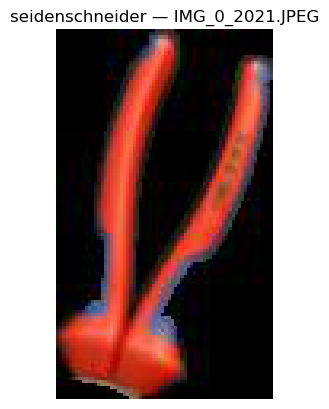

In [ ]:
i = np.random.randint(len(test_paths))
bild = plt.imread(test_paths[i])
label = class_names[y_test_numeric[i]]
plt.imshow(bild)
plt.title(f"{label} — {Path(test_paths[i]).name}")
plt.axis('off')

## ⚠️ WICHTIG: Unterscheidung zwischen `y_test` und `y_pred`

- **`y_test` / `y_test_label`** = **TATSÄCHLICHE Labels** (Ground Truth) - was das Bild wirklich ist
- **`y_pred` / `yhat_label`** = **VORHERSAGEN des Modells** - was das Modell denkt, was das Bild ist

**Wenn Sie `y_test` sehen, sehen Sie NICHT die Vorhersagen des Modells!**


In [ ]:
# ============================================================================
# VERGLEICH: Tatsächliche Labels vs. Modell-Vorhersagen
# ============================================================================
# Diese Zelle zeigt, was das Modell wirklich vorhersagt vs. was tatsächlich ist

print("="*70)
print("VERGLEICH: TATSÄCHLICHE LABELS vs. MODELL-VORHERSAGEN")
print("="*70)

# Prüfe welche Evaluationsergebnisse vorhanden sind
available_models = []

if 'y_true1' in globals() and globals()['y_true1'] is not None:
    available_models.append(('Modell 1 (Simple CNN)', 'y_true1', 'y_pred1'))
if 'y_true2' in globals() and globals()['y_true2'] is not None:
    available_models.append(('Modell 2 (Transfer Learning)', 'y_true2', 'y_pred2'))
if 'y_true3' in globals() and globals()['y_true3'] is not None:
    available_models.append(('Modell 3 (Standard)', 'y_true3', 'y_pred3'))

if len(available_models) == 0:
    print("⚠ Keine Evaluationsergebnisse gefunden!")
    print("  Bitte führen Sie zuerst Zelle 16 (Evaluation) aus.")
else:
    # Zeige für jedes Modell die Vorhersagen
    for model_name, y_true_var, y_pred_var in available_models:
        y_true = globals()[y_true_var]
        y_pred = globals()[y_pred_var]
        
        print(f"\n{'='*70}")
        print(f"{model_name}")
        print("="*70)
        
        # Konvertiere zu Klassennamen
        if 'class_names' in globals():
            y_true_labels = np.array(class_names)[y_true]
            y_pred_labels = np.array(class_names)[y_pred]
            
            # Zeige erste 20 Einträge
            print("\n📊 Erste 20 Vorhersagen:")
            print("-" * 70)
            print(f"{'Bild':<50} {'Tatsächlich':<20} {'Vorhergesagt':<20} {'Korrekt':<10}")
            print("-" * 70)
            
            correct_count = 0
            for i in range(min(20, len(y_true))):
                is_correct = y_true_labels[i] == y_pred_labels[i]
                if is_correct:
                    correct_count += 1
                status = "✓" if is_correct else "✗"
                
                # Bildname (falls test_paths vorhanden)
                if 'test_paths' in globals() and i < len(test_paths):
                    img_name = Path(test_paths[i]).name
                else:
                    img_name = f"Bild_{i}"
                
                print(f"{img_name:<50} {y_true_labels[i]:<20} {y_pred_labels[i]:<20} {status:<10}")
            
            # Zeige Verteilung der Vorhersagen
            print(f"\n📊 Verteilung der VORHERSAGEN (was das Modell sagt):")
            print("-" * 70)
            unique_pred, counts_pred = np.unique(y_pred_labels, return_counts=True)
            for pred_class, count in zip(unique_pred, counts_pred):
                percentage = (count / len(y_pred_labels)) * 100
                print(f"  {pred_class:20s}: {count:3d} Bilder ({percentage:5.1f}%)")
            
            # Zeige Verteilung der tatsächlichen Labels
            print(f"\n📊 Verteilung der TATSÄCHLICHEN Labels (was es wirklich ist):")
            print("-" * 70)
            unique_true, counts_true = np.unique(y_true_labels, return_counts=True)
            for true_class, count in zip(unique_true, counts_true):
                percentage = (count / len(y_true_labels)) * 100
                print(f"  {true_class:20s}: {count:3d} Bilder ({percentage:5.1f}%)")
            
            # Berechne Accuracy
            accuracy = np.mean(y_true_labels == y_pred_labels)
            print(f"\n✓ Accuracy: {accuracy*100:.1f}% ({correct_count}/{min(20, len(y_true))} in den ersten 20)")
            
            # Prüfe ob alle Vorhersagen gleich sind
            if len(np.unique(y_pred_labels)) == 1:
                print(f"\n❌ PROBLEM: Alle Vorhersagen sind '{y_pred_labels[0]}'!")
                print(f"   → Das Modell sagt immer die gleiche Klasse vorher")
                print(f"   → Mögliche Ursache: Klassenreihenfolge-Mismatch oder Modell nicht richtig trainiert")
            else:
                print(f"\n✓ Modell sagt verschiedene Klassen vorher: {len(np.unique(y_pred_labels))} verschiedene Klassen")
        
        print("="*70)


VERGLEICH: TATSÄCHLICHE LABELS vs. MODELL-VORHERSAGEN

Modell 1 (Simple CNN)

📊 Erste 20 Vorhersagen:
----------------------------------------------------------------------
Bild                                               Tatsächlich          Vorhergesagt         Korrekt   
----------------------------------------------------------------------
IMG_0_2128.JPEG                                    schraubenschluessel  schraubenzieher      ✗         
IMG_0_2129.JPEG                                    schraubenschluessel  schraubenzieher      ✗         
IMG_0_2141.JPEG                                    schraubenschluessel  schraubenzieher      ✗         
IMG_0_2147.JPEG                                    schraubenschluessel  schraubenzieher      ✗         
IMG_0_2148.JPEG                                    schraubenschluessel  schraubenzieher      ✗         
IMG_0_2150.JPEG                                    schraubenschluessel  schraubenzieher      ✗         
IMG_0_2156.JPEG             

In [ ]:
# ============================================================================
# UMFASSENDE DIAGNOSE: Warum sagen alle Modelle nur 1 Klasse vorher?
# ============================================================================
# Diese Zelle analysiert systematisch alle möglichen Ursachen

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

print("="*70)
print("🔬 UMFASSENDE DIAGNOSE: WARUM SAGEN ALLE MODELLE NUR 1 KLASSE VORHER?")
print("="*70)

# ============================================================================
# 1. PRÜFUNG: Klassenreihenfolge-Mismatch
# ============================================================================
print("\n" + "="*70)
print("1️⃣ PRÜFUNG: KLASSENREIHENFOLGE-MISMATCH")
print("="*70)

if 'class_names' in globals() and 'expected_class_names' in globals():
    print(f"\n📋 Klassenreihenfolge im Evaluation-Notebook:")
    for i, name in enumerate(class_names):
        print(f"  Index {i}: {name}")
    
    print(f"\n📋 Erwartete Klassenreihenfolge (aus Training):")
    for i, name in enumerate(expected_class_names):
        print(f"  Index {i}: {name}")
    
    if class_names == expected_class_names:
        print("\n✓ Klassenreihenfolge stimmt überein!")
    else:
        print("\n❌ PROBLEM GEFUNDEN: Klassenreihenfolge stimmt NICHT überein!")
        print("   → Das ist wahrscheinlich die Hauptursache!")
        print("   → Lösung: Passe 'class_names' im Evaluation-Notebook an")
        print(f"   → Erwartet: {expected_class_names}")
        print(f"   → Aktuell:  {class_names}")
else:
    print("⚠ 'class_names' oder 'expected_class_names' nicht definiert")

# ============================================================================
# 2. PRÜFUNG: Softmax-Ausgaben analysieren (sind sie wirklich immer gleich?)
# ============================================================================
print("\n" + "="*70)
print("2️⃣ PRÜFUNG: SOFTMAX-AUSGABEN (Wahrscheinlichkeiten)")
print("="*70)

available_models = []
if 'y_pred_proba1' in globals() and globals()['y_pred_proba1'] is not None:
    available_models.append(('Modell 1 (Simple CNN)', 'y_pred_proba1', 'y_pred1'))
if 'y_pred_proba2' in globals() and globals()['y_pred_proba2'] is not None:
    available_models.append(('Modell 2 (Transfer Learning)', 'y_pred_proba2', 'y_pred2'))
if 'y_pred_proba3' in globals() and globals()['y_pred_proba3'] is not None:
    available_models.append(('Modell 3 (Standard)', 'y_pred_proba3', 'y_pred3'))

if len(available_models) == 0:
    print("⚠ Keine Vorhersage-Wahrscheinlichkeiten gefunden!")
    print("  Bitte führen Sie zuerst Zelle 16 (Evaluation) aus.")
else:
    for model_name, proba_var, pred_var in available_models:
        y_pred_proba = globals()[proba_var]
        y_pred = globals()[pred_var]
        
        print(f"\n{model_name}:")
        print("-" * 70)
        
        # Zeige erste 5 Vorhersagen mit Wahrscheinlichkeiten
        print("\n📊 Erste 5 Vorhersagen (Wahrscheinlichkeiten):")
        for i in range(min(5, len(y_pred_proba))):
            probs = y_pred_proba[i]
            pred_idx = y_pred[i]
            if 'class_names' in globals():
                pred_class = class_names[pred_idx]
                print(f"  Bild {i}: Vorhergesagt = {pred_class} (Index {pred_idx}, Wahrscheinlichkeit: {probs[pred_idx]:.3f})")
                print(f"    Alle Wahrscheinlichkeiten: {dict(zip(class_names, probs))}")
            else:
                print(f"  Bild {i}: Vorhergesagt = Index {pred_idx}, Wahrscheinlichkeit: {probs[pred_idx]:.3f}")
                print(f"    Alle Wahrscheinlichkeiten: {probs}")
        
        # Prüfe ob alle Vorhersagen gleich sind
        unique_predictions = np.unique(y_pred)
        print(f"\n📊 Vorhersage-Verteilung:")
        print(f"  Anzahl verschiedene Vorhersagen: {len(unique_predictions)}")
        if len(unique_predictions) == 1:
            print(f"  ❌ PROBLEM: Alle Vorhersagen sind gleich (Index {unique_predictions[0]})!")
            if 'class_names' in globals():
                print(f"  → Alle Bilder werden als '{class_names[unique_predictions[0]]}' klassifiziert")
        else:
            print(f"  ✓ Verschiedene Vorhersagen: {unique_predictions}")
            if 'class_names' in globals():
                print(f"  → Vorhergesagte Klassen: {[class_names[i] for i in unique_predictions]}")
        
        # Prüfe ob die Softmax-Ausgaben sehr ähnlich sind (Modell ist unsicher)
        mean_probs = np.mean(y_pred_proba, axis=0)
        std_probs = np.std(y_pred_proba, axis=0)
        print(f"\n📊 Durchschnittliche Wahrscheinlichkeiten pro Klasse:")
        if 'class_names' in globals():
            for i, class_name in enumerate(class_names):
                print(f"  {class_name:20s}: {mean_probs[i]:.3f} ± {std_probs[i]:.3f}")
        else:
            for i in range(len(mean_probs)):
                print(f"  Klasse {i}: {mean_probs[i]:.3f} ± {std_probs[i]:.3f}")
        
        # Prüfe ob eine Klasse immer die höchste Wahrscheinlichkeit hat
        max_probs = np.max(y_pred_proba, axis=1)
        mean_max_prob = np.mean(max_probs)
        print(f"\n📊 Durchschnittliche maximale Wahrscheinlichkeit: {mean_max_prob:.3f}")
        if mean_max_prob < 0.5:
            print(f"  ⚠ Warnung: Niedrige maximale Wahrscheinlichkeit - Modell ist unsicher")
        elif mean_max_prob > 0.95:
            print(f"  ✓ Hohe maximale Wahrscheinlichkeit - Modell ist sehr sicher")

# ============================================================================
# 3. PRÜFUNG: Datenverteilung (sind die Testdaten ausgewogen?)
# ============================================================================
print("\n" + "="*70)
print("3️⃣ PRÜFUNG: DATENVERTEILUNG")
print("="*70)

if 'y_true1' in globals() and globals()['y_true1'] is not None:
    y_true = globals()['y_true1']
    
    if 'class_names' in globals():
        y_true_labels = np.array(class_names)[y_true]
        unique_true, counts_true = np.unique(y_true_labels, return_counts=True)
        
        print("\n📊 Verteilung der tatsächlichen Labels (Testdaten):")
        print("-" * 70)
        total = len(y_true)
        for true_class, count in zip(unique_true, counts_true):
            percentage = (count / total) * 100
            print(f"  {true_class:20s}: {count:3d} Bilder ({percentage:5.1f}%)")
        
        # Prüfe ob Daten ausgewogen sind
        if len(counts_true) > 0:
            max_count = np.max(counts_true)
            min_count = np.min(counts_true)
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
            print(f"\n📊 Ausgewogenheit:")
            print(f"  Verhältnis größte/kleinste Klasse: {imbalance_ratio:.2f}")
            if imbalance_ratio > 2.0:
                print(f"  ⚠ Warnung: Daten sind unausgewogen (Verhältnis > 2.0)")
            else:
                print(f"  ✓ Daten sind relativ ausgewogen")
else:
    print("⚠ Keine Testdaten-Labels gefunden")

# ============================================================================
# 4. PRÜFUNG: Modell-Architektur (sind die Modelle korrekt aufgebaut?)
# ============================================================================
print("\n" + "="*70)
print("4️⃣ PRÜFUNG: MODELL-ARCHITEKTUR")
print("="*70)

model_vars = []
if 'loaded_model1' in globals():
    model_vars.append(('Modell 1 (Simple CNN)', 'loaded_model1'))
if 'loaded_model2' in globals():
    model_vars.append(('Modell 2 (Transfer Learning)', 'loaded_model2'))
if 'loaded_model3' in globals():
    model_vars.append(('Modell 3 (Standard)', 'loaded_model3'))

if len(model_vars) == 0:
    print("⚠ Keine Modelle geladen!")
else:
    for model_name, model_var in model_vars:
        model = globals()[model_var]
        print(f"\n{model_name}:")
        print("-" * 70)
        
        # Prüfe Output-Layer
        output_layer = model.layers[-1]
        print(f"  Output-Layer: {output_layer.name}")
        print(f"  Output-Aktivierung: {output_layer.activation.__name__ if hasattr(output_layer.activation, '__name__') else str(output_layer.activation)}")
        print(f"  Output-Shape: {output_layer.output_shape}")
        
        if hasattr(output_layer, 'units'):
            print(f"  Anzahl Output-Neuronen: {output_layer.units}")
            if 'class_names' in globals():
                expected_units = len(class_names)
                if output_layer.units == expected_units:
                    print(f"  ✓ Anzahl Output-Neuronen stimmt mit Anzahl Klassen überein ({expected_units})")
                else:
                    print(f"  ❌ PROBLEM: Anzahl Output-Neuronen ({output_layer.units}) stimmt nicht mit Anzahl Klassen ({expected_units}) überein!")
        
        # Prüfe ob Modell trainierbar ist
        trainable_count = sum(1 for layer in model.layers if layer.trainable)
        total_count = len(model.layers)
        print(f"  Trainierbare Layer: {trainable_count}/{total_count}")
        if trainable_count == 0:
            print(f"  ⚠ Warnung: Keine trainierbaren Layer - Modell kann nicht lernen!")

# ============================================================================
# 5. ZUSAMMENFASSUNG & LÖSUNGSVORSCHLÄGE
# ============================================================================
print("\n" + "="*70)
print("5️⃣ ZUSAMMENFASSUNG & LÖSUNGSVORSCHLÄGE")
print("="*70)

print("\n📋 Mögliche Ursachen und Lösungen:")
print("-" * 70)

print("\n1. KLASSENREIHENFOLGE-MISMATCH:")
print("   → Problem: Reihenfolge im Training ≠ Reihenfolge in Evaluation")
print("   → Lösung: Passe 'class_names' im Evaluation-Notebook an die Training-Reihenfolge an")
print("   → Siehe Zelle 5 (Modell-Laden) für die erwartete Reihenfolge")

print("\n2. MODELL LERNT NICHT RICHTIG:")
print("   → Problem: Zu wenig Daten, falsche Hyperparameter, zu aggressive Data Augmentation")
print("   → Lösung: Prüfe Training-Notebook:")
print("     - Sind genug Epochen trainiert? (mindestens 50-100)")
print("     - Ist die Learning Rate zu hoch/niedrig?")
print("     - Ist Data Augmentation zu aggressiv?")
print("     - Sind Class Weights zu extrem?")

print("\n3. SOFTMAX-AUSGABEN SIND IMMER GLEICH:")
print("   → Problem: Modell gibt immer die gleiche Wahrscheinlichkeit aus")
print("   → Lösung: Prüfe ob Modell überhaupt trainiert wurde (Training-Historie)")
print("     - Val_Accuracy sollte steigen")
print("     - Loss sollte sinken")

print("\n4. DATEN SIND ZU UNÄHNLICH:")
print("   → Problem: Testdaten unterscheiden sich zu stark von Trainingsdaten")
print("   → Lösung: Prüfe ob Testdaten genauso verarbeitet werden wie Trainingsdaten")
print("     - Gleiche Bildgröße?")
print("     - Gleiche Normalisierung?")
print("     - Gleiche Preprocessing-Schritte?")

print("\n" + "="*70)
print("✓ DIAGNOSE ABGESCHLOSSEN")
print("="*70)


🔬 UMFASSENDE DIAGNOSE: WARUM SAGEN ALLE MODELLE NUR 1 KLASSE VORHER?

1️⃣ PRÜFUNG: KLASSENREIHENFOLGE-MISMATCH

📋 Klassenreihenfolge im Evaluation-Notebook:
  Index 0: schraubenschluessel
  Index 1: schraubenzieher
  Index 2: seidenschneider

📋 Erwartete Klassenreihenfolge (aus Training):
  Index 0: schraubenschluessel
  Index 1: schraubenzieher
  Index 2: seidenschneider

✓ Klassenreihenfolge stimmt überein!

2️⃣ PRÜFUNG: SOFTMAX-AUSGABEN (Wahrscheinlichkeiten)

Modell 1 (Simple CNN):
----------------------------------------------------------------------

📊 Erste 5 Vorhersagen (Wahrscheinlichkeiten):
  Bild 0: Vorhergesagt = schraubenzieher (Index 1, Wahrscheinlichkeit: 0.491)
    Alle Wahrscheinlichkeiten: {'schraubenschluessel': 0.15405601, 'schraubenzieher': 0.49109456, 'seidenschneider': 0.35484952}
  Bild 1: Vorhergesagt = schraubenzieher (Index 1, Wahrscheinlichkeit: 0.491)
    Alle Wahrscheinlichkeiten: {'schraubenschluessel': 0.15403832, 'schraubenzieher': 0.49113458, 'seidens

AttributeError: 'Dense' object has no attribute 'output_shape'

## 💡 **KONKRETE LÖSUNGSVORSCHLÄGE FÜR DAS TRAINING**

Falls die Diagnose zeigt, dass das Modell nicht richtig lernt, hier konkrete Anpassungen für das Training-Notebook.


In [ ]:
# ============================================================================
# KONKRETE LÖSUNGSVORSCHLÄGE FÜR DAS TRAINING
# ============================================================================
# Diese Zelle zeigt konkrete Anpassungen, die im Training-Notebook gemacht werden sollten

print("="*70)
print("💡 KONKRETE LÖSUNGSVORSCHLÄGE FÜR DAS TRAINING")
print("="*70)

print("\n" + "="*70)
print("🔧 ANPASSUNGEN FÜR semesterarbeit-training.ipynb")
print("="*70)

print("\n1️⃣ LEARNING RATE ANPASSEN:")
print("-" * 70)
print("""
Problem: Learning Rate könnte zu hoch oder zu niedrig sein
→ Zu hoch: Modell lernt nicht stabil, springt zwischen Lösungen
→ Zu niedrig: Modell lernt zu langsam oder gar nicht

Lösung in train_model.py oder direkt im Notebook:
  # Für Transfer Learning (MobileNetV2):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Start mit 0.0001
  # Falls Modell nicht lernt, versuche:
  # - 0.0005 (schneller, aber weniger stabil)
  # - 0.00005 (langsamer, aber stabiler)
  
  # Für Simple CNN:
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Start mit 0.001
  # Falls Modell nicht lernt, versuche:
  # - 0.005 (schneller)
  # - 0.0005 (langsamer, aber stabiler)
""")

print("\n2️⃣ DATA AUGMENTATION REDUZIEREN:")
print("-" * 70)
print("""
Problem: Zu aggressive Data Augmentation kann das Modell verwirren
→ Modell sieht zu viele Variationen und lernt nicht die Grundmerkmale

Lösung in model_transfer_learning.py oder model_simple_cnn.py:
  # Reduziere Augmentation-Parameter:
  data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal"),  # OK
      layers.RandomRotation(0.1),       # Reduziert von 0.2 auf 0.1
      layers.RandomZoom(0.1),           # Reduziert von 0.2 auf 0.1
      layers.RandomBrightness(0.1),     # Reduziert von 0.2 auf 0.1
      layers.RandomContrast(0.1),       # Reduziert von 0.2 auf 0.1
  ])
  
  # ODER: Deaktiviere Augmentation komplett für Test:
  # data_augmentation = tf.keras.Sequential([])  # Leer = keine Augmentation
""")

print("\n3️⃣ CLASS WEIGHTS ANPASSEN:")
print("-" * 70)
print("""
Problem: Class Weights könnten zu extrem sein
→ Eine Klasse wird zu stark gewichtet, andere zu schwach

Lösung in train_model.py (calculate_class_weights Funktion):
  # Aktuelle Formel (inverse Frequenz):
  weight = total_samples / (len(class_names) * count)
  
  # Alternative: Square-root weighting (weniger extrem):
  weight = np.sqrt(total_samples / (len(class_names) * count))
  
  # ODER: Deaktiviere Class Weights komplett:
  # class_weights = None  # Keine Gewichtung
""")

print("\n4️⃣ MEHR EPOCHE TRAINIEREN:")
print("-" * 70)
print("""
Problem: Modell wurde nicht lange genug trainiert
→ Modell hat noch nicht genug gelernt

Lösung in train_model.py oder Notebook:
  # Erhöhe Anzahl Epochen:
  epochs = 200  # Statt 100
  
  # Erhöhe Patience für EarlyStopping:
  patience = 150  # Statt 100 (warte länger auf Verbesserung)
  
  # ODER: Deaktiviere EarlyStopping temporär:
  # early_stopping_callback = None  # Trainiere alle Epochen
""")

print("\n5️⃣ DROPOUT REDUZIEREN:")
print("-" * 70)
print("""
Problem: Zu viel Dropout kann das Lernen verhindern
→ Modell kann keine Muster lernen, weil zu viele Neuronen deaktiviert werden

Lösung in model_transfer_learning.py:
  # Reduziere Dropout:
  x = layers.Dropout(0.3)(x)  # Statt 0.5
  x = layers.Dropout(0.2)(x)  # Statt 0.3
  
  # ODER: Entferne Dropout komplett für Test:
  # x = layers.Dense(128, activation='relu')(x)
  # # Kein Dropout
  # x = layers.Dense(num_classes, activation='softmax')(x)
""")

print("\n6️⃣ FINE-TUNING ANPASSEN:")
print("-" * 70)
print("""
Problem: Base Model (MobileNetV2) ist gefroren oder zu früh aufgetaut
→ Modell kann nicht lernen, weil Basis-Gewichte nicht angepasst werden

Lösung in train_model.py:
  # Für Transfer Learning:
  # Option 1: Fine-Tuning von Anfang an (alle Layer trainierbar)
  model = make_model_transfer_learning(
      image_size=image_size,
      num_classes=num_classes,
      fine_tune=True  # Alle Layer trainierbar
  )
  
  # Option 2: Zuerst Top-Layer trainieren, dann Fine-Tuning
  # Schritt 1: Top-Layer trainieren (fine_tune=False)
  # Schritt 2: Base Model auftauen (base_model.trainable = True)
  # Schritt 3: Mit niedrigerer Learning Rate weiter trainieren
""")

print("\n7️⃣ BATCH SIZE ANPASSEN:")
print("-" * 70)
print("""
Problem: Batch Size könnte zu groß oder zu klein sein
→ Zu groß: Modell lernt zu langsam
→ Zu klein: Modell lernt instabil

Lösung im Notebook:
  # Reduziere Batch Size:
  batch_size = 16  # Statt 32 (mehr Updates pro Epoche)
  
  # ODER: Erhöhe Batch Size:
  batch_size = 64  # Statt 32 (stabileres Training)
""")

print("\n" + "="*70)
print("📋 CHECKLISTE FÜR TRAINING-ANPASSUNGEN")
print("="*70)
print("""
□ 1. Prüfe Training-Historie: Steigt val_accuracy? Sinkt loss?
□ 2. Prüfe Klassenreihenfolge: Stimmt sie zwischen Training und Evaluation?
□ 3. Reduziere Data Augmentation (weniger aggressive Transformationen)
□ 4. Passe Learning Rate an (versuche 0.0001 für Transfer Learning)
□ 5. Reduziere Dropout (0.3 statt 0.5)
□ 6. Erhöhe Anzahl Epochen (200 statt 100)
□ 7. Prüfe Class Weights (sind sie zu extrem?)
□ 8. Stelle sicher, dass Fine-Tuning aktiviert ist (fine_tune=True)
□ 9. Prüfe ob genug Daten vorhanden sind (mindestens 50-100 Bilder pro Klasse)
□ 10. Prüfe ob Testdaten genauso verarbeitet werden wie Trainingsdaten
""")

print("\n" + "="*70)
print("✓ LÖSUNGSVORSCHLÄGE ABGESCHLOSSEN")
print("="*70)


💡 KONKRETE LÖSUNGSVORSCHLÄGE FÜR DAS TRAINING

🔧 ANPASSUNGEN FÜR semesterarbeit-training.ipynb

1️⃣ LEARNING RATE ANPASSEN:
----------------------------------------------------------------------

Problem: Learning Rate könnte zu hoch oder zu niedrig sein
→ Zu hoch: Modell lernt nicht stabil, springt zwischen Lösungen
→ Zu niedrig: Modell lernt zu langsam oder gar nicht

Lösung in train_model.py oder direkt im Notebook:
  # Für Transfer Learning (MobileNetV2):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Start mit 0.0001
  # Falls Modell nicht lernt, versuche:
  # - 0.0005 (schneller, aber weniger stabil)
  # - 0.00005 (langsamer, aber stabiler)

  # Für Simple CNN:
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Start mit 0.001
  # Falls Modell nicht lernt, versuche:
  # - 0.005 (schneller)
  # - 0.0005 (langsamer, aber stabiler)


2️⃣ DATA AUGMENTATION REDUZIEREN:
----------------------------------------------------------------------

Problem: Zu aggr

In [ ]:
# ============================================================================
# EVALUATION ALLER 3 MODELLE MIT VALIDIERUNGSDATEN
# ============================================================================
# Evaluiere alle verfügbaren Modelle mit den Test-/Validierungsdaten
# Verwende die full_evaluation Funktion für umfassende Evaluation

print("="*70)
print("EVALUATION ALLER VERFÜGBAREN MODELLE")
print("="*70)

# Prüfe ob test_ds und class_names vorhanden sind
if 'test_ds' not in globals():
    raise NameError("'test_ds' ist nicht definiert. Bitte führen Sie zuerst die Zelle aus, die test_ds lädt.")
if 'class_names' not in globals():
    raise NameError("'class_names' ist nicht definiert. Bitte führen Sie zuerst die Zelle aus, die class_names lädt.")

# Sammle alle Modelle für Evaluation
models_to_evaluate = []

if 'loaded_model1' in globals():
    models_to_evaluate.append(('Modell 1 (Simple CNN)', 'loaded_model1', f"model_{Datensatzname}_simple_cnn" if 'Datensatzname' in globals() else "model_simple_cnn", 'y_true1', 'y_pred1', 'y_pred_proba1'))

if 'loaded_model2' in globals():
    models_to_evaluate.append(('Modell 2 (Transfer Learning)', 'loaded_model2', f"model_{Datensatzname}_transfer_learning" if 'Datensatzname' in globals() else "model_transfer_learning", 'y_true2', 'y_pred2', 'y_pred_proba2'))

if 'loaded_model3' in globals():
    models_to_evaluate.append(('Modell 3 (Standard)', 'loaded_model3', f"model_{Datensatzname}" if 'Datensatzname' in globals() else "model", 'y_true3', 'y_pred3', 'y_pred_proba3'))

if len(models_to_evaluate) == 0:
    raise NameError("Keine Modelle zum Evaluieren gefunden! Bitte laden Sie zuerst die Modelle in Zelle 5.")

# Evaluiere jedes Modell
for model_name, model_var, model_name_str, y_true_var, y_pred_var, y_pred_proba_var in models_to_evaluate:
    print("\n" + "="*70)
    print(f"EVALUATION: {model_name}")
    print("="*70)
    
    try:
        model = globals()[model_var]
        y_true, y_pred, y_pred_proba = full_evaluation(
            model=model,
            val_ds=test_ds,
            class_names=class_names,
            history=None,  # Keine History verfügbar beim Laden
            model_name=model_name_str
        )
        # Speichere Ergebnisse in globalen Variablen
        globals()[y_true_var] = y_true
        globals()[y_pred_var] = y_pred
        globals()[y_pred_proba_var] = y_pred_proba
        print(f"\n✓ {model_name} erfolgreich evaluiert!")
    except Exception as e:
        print(f"⚠ Fehler bei Evaluation von {model_name}: {e}")
        globals()[y_true_var] = None
        globals()[y_pred_var] = None
        globals()[y_pred_proba_var] = None

# Zusammenfassung
print("\n" + "="*70)
print(f"✓ {len(models_to_evaluate)} MODELL(E) EVALUIERT!")
print("="*70)
print(f"\n📁 Evaluationsergebnisse gespeichert in:")
print(f"   {Path('evaluation_results').absolute()}")
print(f"\n📊 Verfügbare Variablen:")
for model_name, model_var, model_name_str, y_true_var, y_pred_var, y_pred_proba_var in models_to_evaluate:
    if globals().get(y_true_var) is not None:
        print(f"  - {model_name}: {y_true_var}, {y_pred_var}, {y_pred_proba_var}")


EVALUATION ALLER VERFÜGBAREN MODELLE


NameError: 'test_ds' ist nicht definiert. Bitte führen Sie zuerst die Zelle aus, die test_ds lädt.

In [ ]:
# ============================================================================
# VERGLEICHSÜBERSICHT ALLER MODELLE
# ============================================================================
# Erstelle eine Übersichtstabelle mit allen Metriken (Precision, Recall, F1-Score)
# für alle evaluierten Modelle

print("="*70)
print("VERGLEICHSÜBERSICHT ALLER MODELLE")
print("="*70)

# Prüfe welche Modelle geladen wurden
print("\n🔍 Prüfe geladene Modelle:")
loaded_models = []
if 'loaded_model1' in globals():
    loaded_models.append('Modell 1 (Simple CNN)')
    print("  ✓ Modell 1 geladen")
if 'loaded_model2' in globals():
    loaded_models.append('Modell 2 (Transfer Learning)')
    print("  ✓ Modell 2 geladen")
if 'loaded_model3' in globals():
    loaded_models.append('Modell 3 (Standard)')
    print("  ✓ Modell 3 geladen")

if len(loaded_models) == 0:
    print("  ⚠ Keine Modelle geladen! Bitte führen Sie zuerst Zelle 5 aus.")
else:
    print(f"\n  → {len(loaded_models)} Modell(e) geladen: {', '.join(loaded_models)}")

# Sammle alle Evaluationsergebnisse
print("\n🔍 Prüfe Evaluationsergebnisse:")
models_results = {}

if 'y_true1' in globals() and globals()['y_true1'] is not None:
    models_results['Modell 1 (Simple CNN)'] = (globals()['y_true1'], globals()['y_pred1'], globals()['y_pred_proba1'])
    print("  ✓ Modell 1 evaluiert")
elif 'loaded_model1' in globals():
    print("  ⚠ Modell 1 geladen, aber nicht evaluiert")

if 'y_true2' in globals() and globals()['y_true2'] is not None:
    models_results['Modell 2 (Transfer Learning)'] = (globals()['y_true2'], globals()['y_pred2'], globals()['y_pred_proba2'])
    print("  ✓ Modell 2 evaluiert")
elif 'loaded_model2' in globals():
    print("  ⚠ Modell 2 geladen, aber nicht evaluiert")

if 'y_true3' in globals() and globals()['y_true3'] is not None:
    models_results['Modell 3 (Standard)'] = (globals()['y_true3'], globals()['y_pred3'], globals()['y_pred_proba3'])
    print("  ✓ Modell 3 evaluiert")
elif 'loaded_model3' in globals():
    print("  ⚠ Modell 3 geladen, aber nicht evaluiert")

if len(models_results) == 0:
    print("\n" + "="*70)
    print("⚠ KEINE EVALUATIONSERGEBNISSE GEFUNDEN!")
    print("="*70)
    print("\nBitte führen Sie zuerst die Evaluation-Zelle (Zelle 16) aus.")
    print("Diese evaluiert automatisch alle geladenen Modelle.")
    print("\n📋 Zusammenfassung:")
    print(f"  - Geladene Modelle: {len(loaded_models)} ({', '.join(loaded_models) if loaded_models else 'keine'})")
    print(f"  - Evaluierte Modelle: 0")
    print("\n💡 Lösung:")
    print("  1. Stellen Sie sicher, dass Zelle 5 (Modell-Laden) ausgeführt wurde")
    print("  2. Führen Sie Zelle 16 (Evaluation) aus, um alle geladenen Modelle zu evaluieren")
    print("  3. Führen Sie dann diese Zelle erneut aus, um die Vergleichstabelle zu sehen")
else:
    print(f"\n  → {len(models_results)} Modell(e) evaluiert: {', '.join(models_results.keys())}")
    
    # Zeige Warnung, falls nicht alle geladenen Modelle evaluiert wurden
    if len(models_results) < len(loaded_models):
        missing = set(loaded_models) - set(models_results.keys())
        print(f"\n  ⚠ WARNUNG: {len(missing)} Modell(e) geladen, aber nicht evaluiert: {', '.join(missing)}")
        print(f"     → Bitte führen Sie Zelle 16 (Evaluation) erneut aus, um alle Modelle zu evaluieren")
    
    # Prüfe ob create_comparison_table importiert wurde
    if 'create_comparison_table' not in globals():
        print("\n⚠ 'create_comparison_table' nicht importiert!")
        print("  Versuche Import...")
        try:
            from evaluate_model import create_comparison_table
            print("  ✓ Import erfolgreich")
            # Erstelle Vergleichstabelle mit der importierten Funktion
            comparison_df = create_comparison_table(models_results, class_names)
        except ImportError as e:
            print(f"  ❌ Import fehlgeschlagen: {e}")
            print("  Bitte führen Sie Zelle 6 neu aus, um die Funktion zu importieren.")
            # Erstelle manuelle Vergleichstabelle als Fallback
            from sklearn.metrics import classification_report
            import pandas as pd
            
            print("\n📊 MANUELLE VERGLEICHSÜBERSICHT:")
            print("="*70)
            
            comparison_data = []
            for model_name, (y_true, y_pred, y_pred_proba) in models_results.items():
                report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
                comparison_data.append({
                    'Modell': model_name,
                    'Accuracy': report['accuracy'],
                    'Macro Avg Precision': report['macro avg']['precision'],
                    'Macro Avg Recall': report['macro avg']['recall'],
                    'Macro Avg F1-Score': report['macro avg']['f1-score'],
                    'Weighted Avg Precision': report['weighted avg']['precision'],
                    'Weighted Avg Recall': report['weighted avg']['recall'],
                    'Weighted Avg F1-Score': report['weighted avg']['f1-score']
                })
            
            df = pd.DataFrame(comparison_data)
            df = df.sort_values('Accuracy', ascending=False)
            print("\n📊 GESAMT-METRIKEN (Vergleich aller Modelle):")
            print("-" * 70)
            print(df.to_string(index=False, float_format='%.4f'))
            
            print("\n" + "="*70)
            print("DETAILLIERTE METRIKEN PRO KLASSE")
            print("="*70)
            
            for model_name, (y_true, y_pred, y_pred_proba) in models_results.items():
                report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
                print(f"\n{model_name}:")
                print("-" * 70)
                for i, class_name in enumerate(class_names):
                    if str(i) in report:
                        metrics = report[str(i)]
                        print(f"  {class_name}:")
                        print(f"    Precision: {metrics['precision']:.4f}")
                        print(f"    Recall:    {metrics['recall']:.4f}")
                        print(f"    F1-Score:  {metrics['f1-score']:.4f}")
                        print(f"    Support:   {int(metrics['support'])}")
                print(f"\n  Gesamt-Accuracy: {report['accuracy']:.4f}")
                print(f"  Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}")
                print(f"  Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}")
    else:
        # Erstelle Vergleichstabelle mit der importierten Funktion
        comparison_df = create_comparison_table(models_results, class_names)
    
    print("\n" + "="*70)
    print("✓ VERGLEICHSÜBERSICHT ERSTELLT")
    print("="*70)


VERGLEICHSÜBERSICHT ALLER MODELLE

🔍 Prüfe geladene Modelle:
  ✓ Modell 1 geladen
  ✓ Modell 2 geladen
  ✓ Modell 3 geladen

  → 3 Modell(e) geladen: Modell 1 (Simple CNN), Modell 2 (Transfer Learning), Modell 3 (Standard)

🔍 Prüfe Evaluationsergebnisse:
  ✓ Modell 1 evaluiert
  ✓ Modell 2 evaluiert
  ✓ Modell 3 evaluiert

  → 3 Modell(e) evaluiert: Modell 1 (Simple CNN), Modell 2 (Transfer Learning), Modell 3 (Standard)

VERGLEICHSÜBERSICHT ALLER MODELLE

📊 GESAMT-METRIKEN (Vergleich aller Modelle):
--------------------------------------------------------------------------------
                      Modell  Accuracy  Macro Avg Precision  Macro Avg Recall  Macro Avg F1-Score  Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-Score
       Modell 1 (Simple CNN)    0.3810               0.1270            0.3333              0.1839                  0.1451               0.3810                 0.2102
Modell 2 (Transfer Learning)    0.2540               0.0847            0.3333    

d:\dev\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\dev\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\dev\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\dev\anaconda\Lib\site-packages\sklearn\metrics\_classification.p

In [ ]:
print(f"y_test (numerisch): {y_test_numeric[:10]}...")
print(f"yhatnum_test (Vorhersagen): {yhatnum_test[:10]}...")
print(f"\nAnzahl Test-Bilder: {len(y_test_numeric)}")
print(f"Anzahl Vorhersagen: {len(yhatnum_test)}")

y_test (numerisch): [0 0 0 0 0 0 0 0 0 0]...
yhatnum_test (Vorhersagen): [0 0 0 0 0 0 0 0 0 0]...

Anzahl Test-Bilder: 63
Anzahl Vorhersagen: 63


In [ ]:
# ============================================================================
# TRAININGSHISTORIE PLOTTEN MIT PLOT_TRAINING_HISTORY()
# ============================================================================
# Das Plotten wurde in scripts/evaluate_model.py ausgelagert
# Hinweis: Im Evaluation-Notebook ist normalerweise keine History verfügbar,
# da die Modelle nur geladen werden. Diese Zelle funktioniert nur, wenn:
# 1. Das Training-Notebook direkt vorher ausgeführt wurde (history1, history2 vorhanden)
# 2. Oder History-Dateien manuell geladen wurden

from evaluate_model import plot_training_history

# Prüfe ob History-Variablen vorhanden sind
history1_available = 'history1' in globals()
history2_available = 'history2' in globals()

if history1_available or history2_available:
    # Plot History für Modell 1 (falls verfügbar)
    if history1_available:
        print("="*70)
        print("TRAININGSHISTORIE: MODELL 1 (Einfaches CNN)")
        print("="*70)
        try:
            plot_training_history(history1)
            print("✓ Trainingshistorie für Modell 1 geplottet")
        except Exception as e:
            print(f"⚠ Fehler beim Plotten der History für Modell 1: {e}")
    
    # Plot History für Modell 2 (falls verfügbar)
    if history2_available:
        print("\n" + "="*70)
        print("TRAININGSHISTORIE: MODELL 2 (Transfer Learning)")
        print("="*70)
        try:
            plot_training_history(history2)
            print("✓ Trainingshistorie für Modell 2 geplottet")
        except Exception as e:
            print(f"⚠ Fehler beim Plotten der History für Modell 2: {e}")
    
    print("\n" + "="*70)
    print("✓ TRAININGSHISTORIEN GEplottet")
    print("="*70)
else:
    print("="*70)
    print("⚠ HINWEIS: TRAININGSHISTORIE NICHT VERFÜGBAR")
    print("="*70)
    print("\nIm Evaluation-Notebook sind normalerweise keine Trainingshistorien verfügbar,")
    print("da die Modelle nur geladen werden (nicht trainiert).")
    print("\nUm die Trainingshistorie zu sehen:")
    print("  1. Führen Sie das Training-Notebook (semesterarbeit-training.ipynb) aus")
    print("  2. Oder führen Sie diese Zelle direkt nach dem Training aus")
    print("  3. Die History wird automatisch in full_evaluation() geplottet")
    print("\nDie Evaluationsergebnisse (Confusion Matrix, Classification Report) sind")
    print("trotzdem verfügbar und wurden bereits oben erstellt.")


⚠ HINWEIS: TRAININGSHISTORIE NICHT VERFÜGBAR

Im Evaluation-Notebook sind normalerweise keine Trainingshistorien verfügbar,
da die Modelle nur geladen werden (nicht trainiert).

Um die Trainingshistorie zu sehen:
  1. Führen Sie das Training-Notebook (semesterarbeit-training.ipynb) aus
  2. Oder führen Sie diese Zelle direkt nach dem Training aus
  3. Die History wird automatisch in full_evaluation() geplottet

Die Evaluationsergebnisse (Confusion Matrix, Classification Report) sind
trotzdem verfügbar und wurden bereits oben erstellt.


Das ist nun also der Klassenindex- da wir die Bilder nicht "geshuffled" haben, ist zumindest die Sequenz `y_test` monoton. Bei `yhatnum_test` (also unseren Vorhersagen auf diesen Bildern) gibt es einige wenige Abweichungen. Das ist zu erwarten. Wenn wir nur wüssten, welcher Klasse das zugehört?!  
Aber weil wir zu neugierig sind, wie gut das Modell sein könnte, rechnen wir ohne dieses Wissen mal die Genauigkeit aus:

In [ ]:
Genauigkeit = np.mean(np.where(y_test_numeric==yhatnum_test,1,0)) 
# np.where könnte man auch weglassen, so: Genauigkeit = np.mean(y_test==yhatnum_test). 
# Aber was ist der Mittelwert von True, False, True? 
# Klarer ist's wenn wir mit where ersetzen: True->1 und False->0
assert Genauigkeit==np.mean(y_test_numeric==yhatnum_test) # Ergibt einen Fehler, sollte das mal nicht mehr stimmen
print(f'Die Testgenauigkeit ist {100*Genauigkeit:3.1f}%.')

Die Testgenauigkeit ist 25.4%.


Nun würden wir also auch gerne die Label kennen. Wir müssen den Labelindex (die Zahl) mit dem Namen der Klasse in Verbindung bringen. Zum Glück werden die Klassenlabel sortiert durchgezählt, so dass dieser Schritt nicht schwer ist:

In [ ]:
# Verwende die class_names aus dem Dataset (bereits sortiert)
sorted_class_labels = np.array(class_names)
print(f"Sortierte Klassenlabels ({len(sorted_class_labels)} Klassen):")
print(sorted_class_labels)

Sortierte Klassenlabels (3 Klassen):
['schraubenschluessel' 'schraubenzieher' 'seidenschneider']


In [ ]:
print(f"Test-Bilder: {len(test_paths)} Dateien")
print(f"Vorhersagen: {len(yhatnum_test)} Werte")
print(f"\nErste 5 Vorhersagen (Indices): {yhatnum_test[:5]}")
print(f"Entsprechende Klassen: {sorted_class_labels[yhatnum_test[:5]]}")

Test-Bilder: 63 Dateien
Vorhersagen: 63 Werte

Erste 5 Vorhersagen (Indices): [0 0 0 0 0]
Entsprechende Klassen: ['schraubenschluessel' 'schraubenschluessel' 'schraubenschluessel' 'schraubenschluessel' 'schraubenschluessel']


In [ ]:
yhat_label = pd.Series(sorted_class_labels[yhatnum_test], index=test_paths)
y_test_label = pd.Series(sorted_class_labels[y_test_numeric], index=test_paths)
# das vorhergesagte Label:
print("Vorhergesagte Labels (erste 10):")
print(yhat_label.head(10))

Vorhergesagte Labels (erste 10):
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2128.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2129.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2141.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2147.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2148.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2150.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2156.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2164.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2182.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2183.JPEG    schraubenschluessel
dtype: object


In [ ]:
# und das Tatsächliche:
y_test_label

Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2128.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2129.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2141.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2147.JPEG    schraubenschluessel
Baumstruktur\Baumstruktur_test\schraubenschluessel\IMG_0_2148.JPEG    schraubenschluessel
                                                                             ...         
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2097.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2101.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2108.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2118.JPEG            seidenschneider
Baumstruktur\Baumstruktur_test\seidenschneider\IMG_0_2119.JPEG            seidenschneider
Length: 63

In [ ]:
# Natürlich muss die gleiche Genauigkeit rauskommen, wenn wir sie mit den Labels berechnen, anstatt mit den Labelindices:
Genauigkeit2 = (yhat_label==y_test_label).mean()
print(f'Die Testgenauigkeit ist {100*Genauigkeit2:3.1f}%.')

Die Testgenauigkeit ist 25.4%.


Schliesslich können wir uns noch die Wahrscheinlichkeit merken, mit welcher das Neuronale Netz eine Klasse identifiziert hat. Dies ist also die grösste Zahl unter den $P(y=c_i|X)$ für alle Klassen $c_1$,...,$c_C$ ($C$ der Anzahl Klassen unseres Problems, `yhat_test.shape[1]`.

In [ ]:
P = np.max(yhat_test,axis=1)
P.shape

(63,)

# Scikit-Plot
Wir sind bereit! Wir kennen die Testbilder, deren zugehörige Klassenlabel und Vorhersagen durch das geladene Modell. Wir folgen der Dokumentation [hier](https://scikit-plot.readthedocs.io/en/stable/metrics.html). Berechnen wir Metriken! Wir beginnen mit der Confusion Matrix:

Classification Report:
                     precision    recall  f1-score   support

schraubenschluessel       0.25      1.00      0.41        16
    schraubenzieher       0.00      0.00      0.00        24
    seidenschneider       0.00      0.00      0.00        23

           accuracy                           0.25        63
          macro avg       0.08      0.33      0.14        63
       weighted avg       0.06      0.25      0.10        63



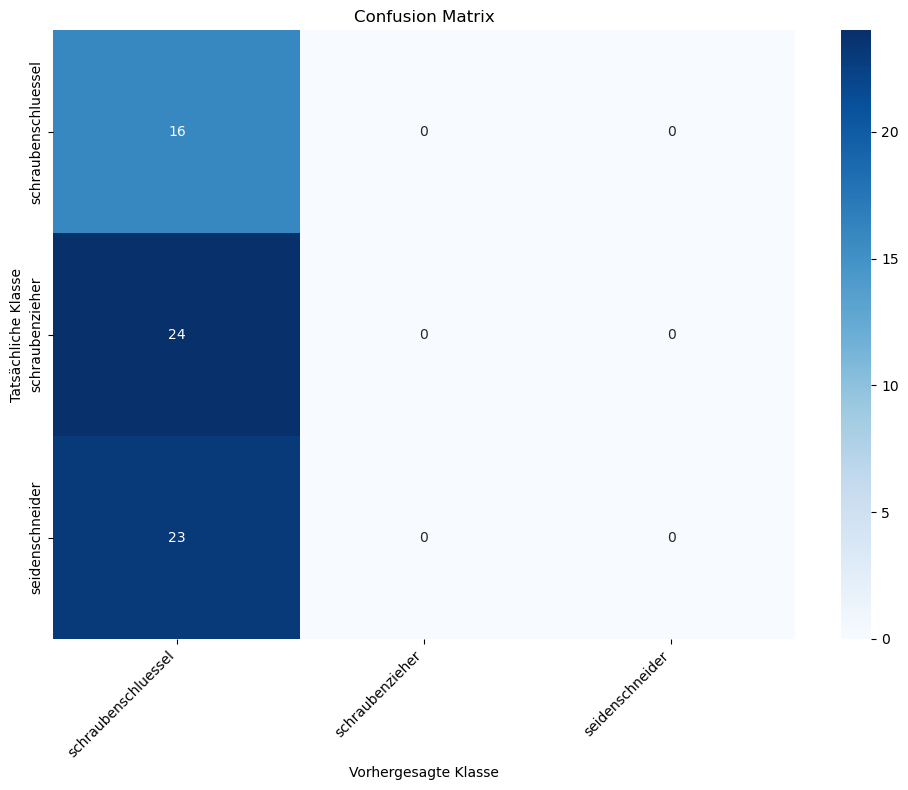

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_label, yhat_label, zero_division=0))

# Confusion Matrix (verwendet scikit-plot oder Alternative)
scikitplot.metrics.plot_confusion_matrix(
    y_test_label.values, 
    yhat_label.values, 
    labels=sorted_class_labels, 
    x_tick_rotation=45
)
plt.tight_layout()
plt.show()

Beachten Sie, wie hübsch blockdiagonal die confusion matrix geworden ist. Dies zeigt, dass das Modell sich meist in der Form, und selten bis nie in der Farbe irrt.  
Ein offensichtliches Problem ist natürlich, dass wir den Grossteil der Daten zum Training benutzt haben (das ist gängige Praxis), und nun nur wenige Beispiele (pro Klasse) übrig haben, um die Präzision und den Recall der Klasse zu schätzen. Mehr Daten wären schon praktisch...

In [ ]:
display((y_test_label==yhat_label).value_counts())
print('-'*30)
for curr_class_str in yhat_label.unique():
    curr_class_results=(y_test_label[y_test_label==curr_class_str]==yhat_label[y_test_label==curr_class_str])
    print(f'{curr_class_str:<10}:{100*curr_class_results.mean():3.0f}%')

False    47
True     16
Name: count, dtype: int64

------------------------------
schraubenschluessel:100%


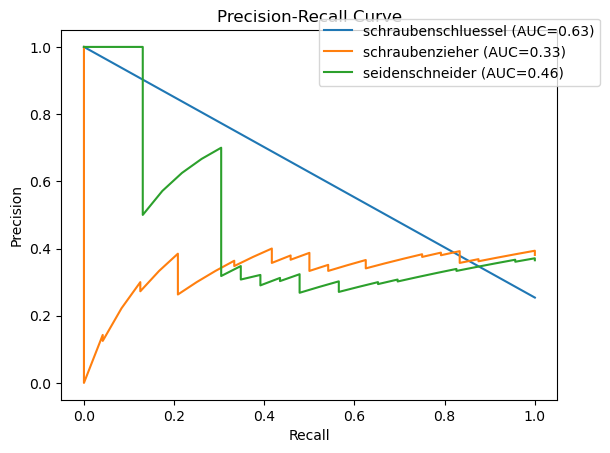

In [ ]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_precision_recall(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

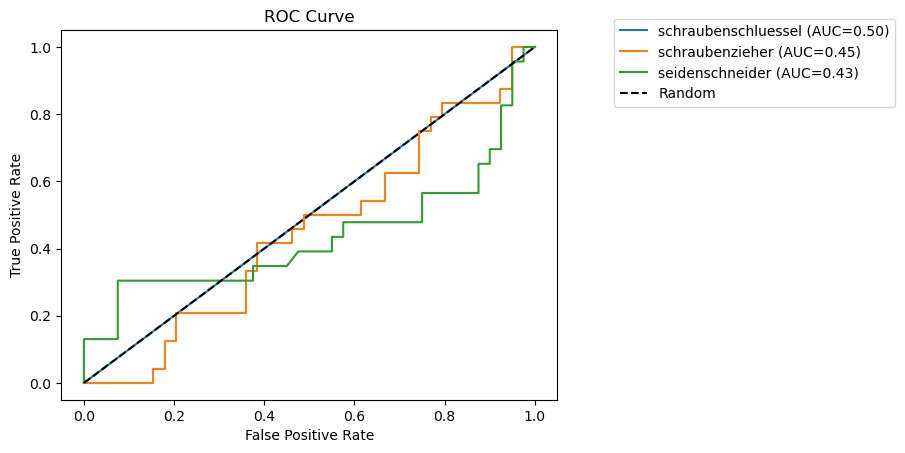

In [ ]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_roc(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

Ein Problem hier ist, dass das neuronale Netz für recht viele Klassen ("area=1.000") eine extreme Precision-Recall-Kurve ausgibt- von (0,1) über (1,1) nach (1,0). Aber wer würde sich schon darüber beklagen!

Zur Erinnerung, dies ist das Modell, das die obigen Resultate erziehlt hat. Wir können es grundsätzlich irgendwo (auf einem Raspberry-Pi?) laden und dort Vorhersagen generieren.

In [ ]:
loaded_model.layers[-1]

<Dense name=Ausgabe, built=True>

In [ ]:
loaded_model.summary()

Model: "MobileNetV2-Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Eingabe (InputLayer)            │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ausgabe (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,198,795 (27.46 MB)

 Trainable params: 2,388,227 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,776,456 (18.22 MB)

# Conv Layer Outputs
In den nächsten paar Zeilen werden wir ("spasseshalber", ist nicht weiter wichtig), den Output der letzten Conv-Schicht ausgeben und visualisieren.

**Hinweis**: Der Code findet automatisch die letzte Conv2D-Schicht, unabhängig vom Layer-Namen.

In [ ]:
# Finde automatisch die letzte Conv2D-Schicht (robust gegen verschiedene Layer-Namen)
# Unterstützt sowohl einfache CNN-Modelle als auch Transfer-Learning-Modelle (MobileNetV2, etc.)

def find_conv_layers(model):
    """Findet Conv2D-Schichten im Modell, auch in Submodellen (z.B. MobileNetV2)"""
    conv_layers = []
    
    # 1. Suche in Top-Level-Layern
    for layer in model.layers:
        # Prüfe ob Layer selbst Conv2D ist
        if isinstance(layer, tf.keras.layers.Conv2D):
            conv_layers.append(layer)
        # Prüfe ob Layer ein Submodell ist (z.B. MobileNetV2 Base-Modell)
        elif hasattr(layer, 'layers') and len(layer.layers) > 0:
            # Rekursiv in Submodell suchen
            sub_conv = find_conv_layers(layer)
            conv_layers.extend(sub_conv)
    
    return conv_layers

# Suche nach Conv2D-Schichten
conv_layers = find_conv_layers(loaded_model)

if conv_layers:
    conv_layer = conv_layers[-1]  # Nimm die letzte Conv2D-Schicht
    print(f"✓ Gefundene Conv2D-Schicht: {conv_layer.name}")
    print(f"  Typ: {type(conv_layer).__name__}")
    print(f"  Anzahl gefundener Conv2D-Schichten: {len(conv_layers)}")
    if len(conv_layers) <= 10:
        print(f"  Verfügbare Conv2D-Schichten: {[l.name for l in conv_layers]}")
    else:
        print(f"  Erste 5: {[l.name for l in conv_layers[:5]]}")
        print(f"  Letzte 5: {[l.name for l in conv_layers[-5:]]}")
else:
    # Fallback: Verwende die letzte Schicht vor GlobalAveragePooling2D oder Dense
    print("⚠️ Keine Conv2D-Schicht direkt gefunden. Suche nach alternativer Schicht...")
    for i, layer in enumerate(loaded_model.layers):
        if isinstance(layer, (tf.keras.layers.GlobalAveragePooling2D, tf.keras.layers.Dense)):
            if i > 0:
                # Verwende die vorherige Schicht
                conv_layer = loaded_model.layers[i-1]
                print(f"✓ Verwende alternative Schicht: {conv_layer.name} (Typ: {type(conv_layer).__name__})")
                break
    else:
        raise ValueError("Keine geeignete Schicht für Feature-Visualisierung gefunden!")

✓ Gefundene Conv2D-Schicht: Conv_1
  Typ: Conv2D
  Anzahl gefundener Conv2D-Schichten: 35
  Erste 5: ['Conv1', 'expanded_conv_project', 'block_1_expand', 'block_1_project', 'block_2_expand']
  Letzte 5: ['block_15_expand', 'block_15_project', 'block_16_expand', 'block_16_project', 'Conv_1']


In [ ]:
from tensorflow.keras import Model, Input

# Erstelle Feature-Modell für Visualisierung
# Bei Transfer-Learning-Modellen müssen wir den vollständigen Pfad durch Rescaling/Data Augmentation berücksichtigen

print("Erstelle Feature-Modell für Visualisierung...")

# Strategie 1: Finde das Base-Modell (MobileNetV2) direkt
base_model_layer = None
for layer in loaded_model.layers:
    # MobileNetV2 wird als Functional-Modell gespeichert
    if isinstance(layer, tf.keras.Model) and hasattr(layer, 'layers') and len(layer.layers) > 10:
        # Prüfe ob es MobileNetV2 ist
        if 'mobilenet' in layer.name.lower() or any('mobilenet' in str(type(sublayer).__name__).lower() for sublayer in layer.layers[:5]):
            base_model_layer = layer
            print(f"✓ Gefunden: Base-Modell '{layer.name}'")
            break

# Strategie 2: Finde die Schicht direkt vor GlobalAveragePooling2D
feature_output = None
found_layer_name = None

if base_model_layer is None:
    for i, layer in enumerate(loaded_model.layers):
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
            if i > 0:
                prev_layer = loaded_model.layers[i-1]
                # Wenn es ein Base-Modell ist, verwende es
                if isinstance(prev_layer, tf.keras.Model):
                    base_model_layer = prev_layer
                    print(f"✓ Gefunden: Base-Modell vor GlobalAveragePooling2D = '{prev_layer.name}'")
                    break
                else:
                    feature_output = prev_layer.output
                    found_layer_name = prev_layer.name
                    print(f"✓ Gefunden: Schicht vor GlobalAveragePooling2D = '{found_layer_name}'")
                    print(f"  Typ: {type(prev_layer).__name__}")
                    break

# Strategie 3: Verwende Base-Modell direkt (ohne Data Augmentation)
if base_model_layer is not None:
    try:
        # Erstelle neues Input für Base-Modell (ohne Data Augmentation)
        # Base-Modell erwartet bereits rescaled Input (0-1)
        base_input = Input(shape=base_model_layer.input_shape[1:], name='base_input')
        base_output = base_model_layer(base_input, training=False)
        
        feature_model = Model(
            inputs=base_input,
            outputs=base_output,
            name="FeatureExtractor"
        )
        print(f"✓ Feature-Modell erfolgreich erstellt (Base-Modell: '{base_model_layer.name}')")
        
        # Teste das Modell - Base-Modell erwartet rescaled Input (0-1)
        test_input = tf.random.uniform((1, 128, 128, 3), minval=0.0, maxval=1.0)
        test_output = feature_model(test_input, training=False)
        print(f"✓ Test erfolgreich: Output-Shape = {test_output.shape}")
        
    except Exception as e:
        print(f"❌ Fehler beim Erstellen mit Base-Modell: {e}")
        base_model_layer = None

# Fallback: Verwende die bereits gefundene Conv2D-Schicht
if base_model_layer is None and feature_output is None:
    if 'conv_layer' in globals() and conv_layer is not None:
        try:
            print(f"⚠️ Verwende Fallback: Conv2D-Schicht '{conv_layer.name}'")
            # Versuche mit Rescaling, aber ohne Data Augmentation
            # Finde Rescaling-Schicht
            rescaling_layer = None
            for layer in loaded_model.layers:
                if isinstance(layer, tf.keras.layers.Rescaling):
                    rescaling_layer = layer
                    break
            
            if rescaling_layer is not None:
                # Erstelle Input und wende Rescaling an
                feature_input = Input(shape=loaded_model.input_shape[1:], name='feature_input')
                x = rescaling_layer(feature_input)
                # Finde den Pfad von Rescaling zu Conv2D
                # Dies ist komplex, daher verwenden wir einen einfacheren Ansatz
                feature_model = Model(
                    inputs=loaded_model.input,
                    outputs=conv_layer.output,
                    name="FeatureExtractor"
                )
            else:
                feature_model = Model(
                    inputs=loaded_model.input,
                    outputs=conv_layer.output,
                    name="FeatureExtractor"
                )
            
            print(f"✓ Feature-Modell erfolgreich erstellt (Output: '{conv_layer.name}')")
            
            # Teste das Modell - Input muss durch Rescaling gehen
            test_input = tf.random.normal((1, 128, 128, 3))
            test_output = feature_model(test_input, training=False)
            print(f"✓ Test erfolgreich: Output-Shape = {test_output.shape}")
            
        except Exception as e2:
            print(f"❌ Auch Conv2D-Ansatz fehlgeschlagen: {e2}")
            print(f"   Fehlerdetails: {type(e2).__name__}: {str(e2)[:200]}")
            raise ValueError(f"Feature-Modell konnte nicht erstellt werden. Versuchen Sie, das Modell neu zu trainieren oder verwenden Sie ein anderes Modell.")
    else:
        raise ValueError("Konnte keine geeignete Schicht für Feature-Extraktion finden!")


Erstelle Feature-Modell für Visualisierung...
✓ Gefunden: Base-Modell 'mobilenetv2_1.00_128'
✓ Feature-Modell erfolgreich erstellt (Base-Modell: 'mobilenetv2_1.00_128')
✓ Test erfolgreich: Output-Shape = (1, 4, 4, 1280)


In [ ]:
from PIL import Image
import numpy as np

color_image_size = (128, 128)  # MUSS mit Training übereinstimmen!

# Verwende ein Test-Bild aus dem Dataset
if len(test_paths) > 0:
    # Wähle zufällig ein Bild aus den Test-Daten
    test_image_path = test_paths[np.random.randint(len(test_paths))]
    print(f"Verwende Test-Bild: {test_image_path}")
    
    im = Image.open(test_image_path)
    im_resized = im.resize(color_image_size, Image.Resampling.LANCZOS)
    img = np.array(im_resized) / 255.0  # Normalisierung
    
    # Batch-Dimension hinzufügen
    img_batch = img.reshape(1, *color_image_size, 3)
else:
    raise ValueError("Keine Test-Bilder gefunden!")


Verwende Test-Bild: Baumstruktur\Baumstruktur_test\schraubenzieher\IMG_0_1911.JPEG


In [ ]:
feature_maps = feature_model.predict(img_batch)
print("Feature-Map Shape:", feature_maps.shape) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
Feature-Map Shape: (1, 4, 4, 1280)


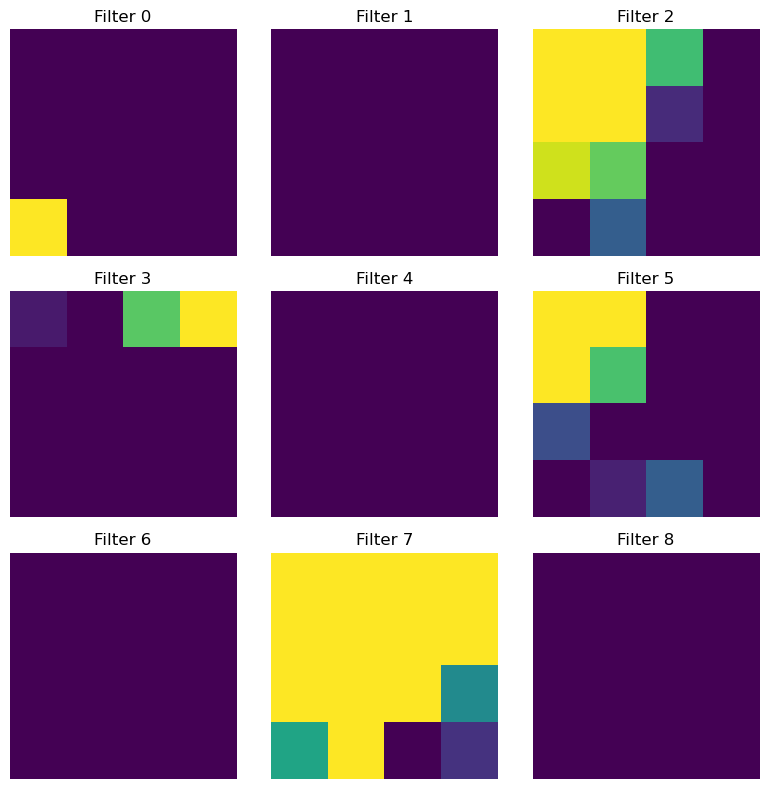

In [ ]:
import matplotlib.pyplot as plt

# Einzeln anzeigen (z. B. die ersten 9 Kanäle)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
    ax.set_title(f'Filter {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()
